In [1]:
cd ..

/home/hantoine/Documents/Cours/Concordia/2019-Winter/SOEN_691_Big_Data_Analytics/project/accident-prediction-montreal


In [2]:
%matplotlib inline
import sys
sys.path.insert(0, '/home/hantoine/concordia/bigdata/project/spark/python')

In [3]:
from preprocess import get_negative_samples, get_positive_samples
from utils import init_spark
spark = init_spark()
spark.version

Spark Session created
Parameters:
	spark.driver.extraClassPath: ./data/xgboost4j-spark-0.72.jar:./data/xgboost4j-0.72.jar
	spark.network.timeout: 300s
	spark.master: local[10]
	spark.executor.id: driver
	spark.cleaner.periodicGC.interval: 5min
	spark.driver.port: 39845
	spark.app.name: Accident prediction
	spark.serializer: org.apache.spark.serializer.KryoSerializer
	spark.driver.memory: 7g
	spark.rdd.compress: True
	spark.driver.host: laptop-hantoine
	spark.serializer.objectStreamReset: 100
	spark.app.id: local-1555769809646
	spark.submit.pyFiles: 
	spark.submit.deployMode: client
	spark.ui.showConsoleProgress: true


'3.0.0-SNAPSHOT'

In [4]:
# from weather import get_weather_df
# from pyspark.sql.functions import col
# weather_df = get_weather_df(spark, None)
# (weather_df
#  .filter((col('date') == datetime.fromisoformat('2014-01-17').date()) & (col('hour') == 15))
#  .select('station_id', 'rel_hum', 'visibility', 'stn_press', 'temp', 'risky_weather')
#  .dropna(how='all', subset=['rel_hum', 'visibility', 'stn_press', 'temp'])
#  .show())

# from preprocess import get_weather_information
# from weather import get_weather_df

# weather_df = get_weather_df(spark, None)
# (get_weather_information(sample, weather_df)
#  .select('rel_hum', 'visibility', 'stn_press', 'temp', 'risky_weather')
#  .show())

In [5]:
# from datetime import datetime
# sample = spark.createDataFrame([(0, datetime.fromisoformat('2014-01-17').date(), 15, -73.66106428971901, 45.48674117457887)],
#                       ['sample_id', 'date', 'hour', 'loc_long', 'loc_lat'])
# sample.show()

In [6]:
neg_samples = get_negative_samples(spark).sample(0.5)
pos_samples = get_positive_samples(spark)
# pos_samples.write.parquet('data/pos_samples_0.2.parquet')
# neg_samples.write.parquet('data/neg_samples_0.2.parquet')
# pos_samples = spark.read.parquet('data/pos_samples_0.2.parquet')
# neg_samples = spark.read.parquet('data/neg_samples_0.2.parquet')

In [7]:
# from accidents_montreal import get_accident_df
# from weather import get_weather_station_coords_df
# from operator import and_
# acc = get_accident_df(spark)
# weather_stations = get_weather_station_coords_df(spark, None)
# def write_to_KML_file(row):
#     with open(f'./data/kml_stations/{str(row.station_id)}.kml', 'w') as file:
#         file.write(f"""<?xml version="1.0" encoding="UTF-8"?>
# <kml xmlns="http://www.opengis.net/kml/2.2">
#   <Document>
#   <Placemark>
#     <name>Station {row.station_id}</name>
#     <Point>
#       <coordinates>{row.station_long},{row.station_lat},0</coordinates>
#     </Point>
#   </Placemark>
#   </Document>
# </kml>
# """)
#     return True
# weather_stations.rdd.map(write_to_KML_file).reduce(and_)

In [8]:
# neg_samples.select(avg('visibility'), stddev('visibility')).show()
# pos_samples.select(avg('visibility'), stddev('visibility')).show()

In [9]:
# pos_samples.filter(col('date') == datetime.fromisoformat('2016-06-19')).select(avg('visibility'), stddev('visibility'), count('sample_id')).show()

In [10]:
# from road_network import get_road_features_df
# from pyspark.sql.functions import *
# from pyspark.sql import Window
# road = get_road_features_df(spark)
# col_name = 'street_id'
# street_risk_rank = \
#     (pos_samples
#      .select(col_name)
#      .na.fill("unknown")
#      .groupBy(col_name).count()
#      .withColumn('risk', col('count') / lit(pos_samples.count()))
#      .drop('count')
#      .join(road.select('street_id'), 'street_id', 'outer')
#      .na.fill(0, ['risk'])
#      .withColumn(col_name + '_indexed',
#                  row_number().over(Window.orderBy(col('risk').desc())))
#      .drop('risk')
#     )
# # street_risk_rank.orderBy('street_id_indexed').show(n=100)

# pos_samples = pos_samples.join(street_risk_rank, 'street_id')
# neg_samples = neg_samples.join(street_risk_rank, 'street_id')
# neg_samples.count()

In [11]:
from datetime import datetime
from pyspark.sql.functions import *
train_pos = \
    (pos_samples
    .filter(col('date') < datetime.fromisoformat('2017-01-01')))
train_neg = \
    (neg_samples
    .filter(col('date') < datetime.fromisoformat('2017-01-01')))
test_pos = \
    (pos_samples
    .filter(col('date') >= datetime.fromisoformat('2017-01-01')))
test_neg = \
    (neg_samples
    .filter(col('date') >= datetime.fromisoformat('2017-01-01')))

In [12]:
train_pos.count()

113450

In [13]:
train_neg.count()

967632

In [14]:
from road_network import get_road_features_df
from pyspark.sql.functions import *
from pyspark.sql import Window
road = get_road_features_df(spark)
street_accident_count = \
    (train_pos
     .select('street_id')
     .groupBy('street_id').count()
     .join(road.select('street_id'), 'street_id', 'outer')
     .na.fill(0, ['count'])
     .withColumnRenamed('count', 'accident_count')
    )

train_pos = train_pos.join(street_accident_count, 'street_id')
train_neg = train_neg.join(street_accident_count, 'street_id')
test_pos = test_pos.join(street_accident_count, 'street_id')
test_neg = test_neg.join(street_accident_count, 'street_id')

Skip extracting road features: already done


In [15]:
train_pos.count()

113450

In [16]:
from pyspark.ml.feature import VectorAssembler
from preprocess import get_dataset_df, features_col, remove_positive_samples_from_negative_samples

lvl_i, typ_i, train_set = get_dataset_df(spark, train_pos, train_neg)

test_neg = remove_positive_samples_from_negative_samples(test_neg,
                                                            test_pos)
test_pos = test_pos.withColumn('label', lit(1.0))
test_neg = test_neg.withColumn('label', lit(0.0))

test_pos = test_pos.select(*test_neg.columns)
test_set = test_pos.union(test_neg)
test_set = test_set.join(lvl_i, 'street_level').drop('street_level')
test_set = test_set.join(typ_i, 'street_type').drop('street_type')

assembler = VectorAssembler(outputCol="features",
                                inputCols=features_col,
                                handleInvalid='keep'
                                )
test_set = (assembler.transform(test_set)
      .select('sample_id',
              'street_id',
              'date', 'hour', 'features', 'label'))

Skip extracting road features: already done
Skip extracting road features: already done


In [17]:
imbalance_ratio = (train_neg.count()/train_pos.count())
print(f"Imbalance ratio: {imbalance_ratio}")

Imbalance ratio: 8.52914940502424


In [18]:
# from preprocess import get_dataset_df
# df = get_dataset_df(spark, pos_samples, neg_samples)
# df = df.persist()
# df.count()

In [19]:
# from pyspark.sql.functions import col
# from datetime import datetime
# df_sample = df.filter(col('date') > datetime.fromisoformat('2017-01-01'))
# df_sample.count()

In [20]:
# from random_undersampler import RandomUnderSampler

# (train_set, test_set) = df.randomSplit([0.7, 0.3])
# ru = RandomUnderSampler().setIndexCol('id')
# model = ru.fit(train_set)
# train_set = model.transform(train_set)
# test_set = model.transform(test_set)
# print(train_set.count(), test_set.count())

In [21]:
# from pyspark.sql.functions import udf, col
# from pyspark.sql.types import ArrayType, DoubleType
# from random_forest import features_col
# dayofweek_features = [f'{features_col[-1]}_{i}' for i in range(1, 8)]
# feature_names = features_col[:-1] + dayofweek_features

# def extract_X(samples):
#     def to_array(col):
#         def to_array_(v):
#             return v.toArray().tolist()
#         return udf(to_array_, ArrayType(DoubleType()))(col)
#     X = (samples
#          .select(to_array('features').alias('fa'))
#          .select([col("fa")[i] for i in range(26)]))
#     X = X.toDF(*feature_names)
#     #return X
#     return X.toPandas()#.values

# trainX = extract_X(train_set)
# # testX = extract_X(test_set)
# trainy = train_set.select('label').toPandas().values.T
# # trainx = test_set.select('label').toPandas().values.T

In [22]:
# trainX.count()

In [23]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import auc
# from sklearn.ensemble import RandomForestClassifier
# from matplotlib import pyplot

# model = RandomForestClassifier(n_estimators=100)
# model.fit(trainX, trainy)
# # predict probabilities
# probs = model.predict_proba(testX)
# # keep probabilities for the positive outcome only
# probs = probs[:, 1]
# # predict class values
# yhat = model.predict(testX)
# # calculate precision-recall curve
# precision, recall, thresholds = precision_recall_curve(testy, probs)
# # calculate precision-recall AUC
# auc = auc(recall, precision)
# print('auc=%.3f' % auc)
# # plot no skill
# pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# # plot the precision-recall curve for the model
# pyplot.plot(recall, precision, marker='.')
# # show the plot
# pyplot.show()

In [24]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml import Pipeline
from random_undersampler import RandomUnderSampler
from class_weighter import ClassWeighter



# (train_set, test_set) = df.randomSplit([0.8, 0.2])

rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            cacheNodeIds=True,
                            maxDepth=17,
                            impurity='entropy',
                            featureSubsetStrategy='sqrt',
#                             weightCol='weight',
                            minInstancesPerNode=10,
                            numTrees=100,
                            subsamplingRate=1.0,
                            maxMemoryInMB=768
                           )
ru = RandomUnderSampler().setIndexCol('id').setTargetImbalanceRatio(1.0)
cw = ClassWeighter().setClassWeight([1/imbalance_ratio, 1.0])
pipeline = Pipeline().setStages([
                                 ru,
#                                  cw,
                                 rf])
model = pipeline.fit(train_set)

In [25]:
# paramGrid = (ParamGridBuilder()
#      .addGrid(rf.numTrees, [100])
#     .addGrid(rf.featureSubsetStrategy, ['sqrt'])
#     .addGrid(rf.impurity, ['entropy'])
#     .addGrid(rf.maxDepth, [17])
#      .addGrid(rf.minInstancesPerNode, [10])
#      .addGrid(rf.subsamplingRate, [1.0])
# #     .addGrid(ru.targetImbalanceRatio, [1.0, 2.0, 3.0, 5.0, 7.0])
#     .addGrid(ru.targetImbalanceRatio, [1.0])
# #     .addGrid(cw.classWeight, [[1/imbalance_ratio, 1.0]])
#     .build())
# PR_evaluator = BinaryClassificationEvaluator(labelCol="label",
#                                              rawPredictionCol="rawPrediction",
#                                              metricName="areaUnderPR")
# tvs = CrossValidator(estimator=pipeline,
#                            estimatorParamMaps=paramGrid,
#                            evaluator=PR_evaluator,
# #                            trainRatio=0.7,
#                            collectSubModels=True)
# model = tvs.fit(train_set)
# model.avgMetrics

In [26]:
def print_params(model):
    for stage in model.stages:
        params = stage.extractParamMap()
        for k in params:
            print(f'{k.name}: {params[k]}')

print_params(model)

targetImbalanceRatio: 1.0
cacheNodeIds: True
checkpointInterval: 10
featureSubsetStrategy: sqrt
featuresCol: features
impurity: entropy
labelCol: label
maxBins: 32
maxDepth: 17
maxMemoryInMB: 768
minInfoGain: 0.0
minInstancesPerNode: 10
numTrees: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -4598544264785588757
subsamplingRate: 1.0


In [27]:
# predictions = model.transform(test_set)

In [28]:
# Since test_set does not contain ids and random undersmapler is expecting one
# and we don't want to add id to test_set since some of them could match the ones in the training set 
# which would result in test examples to be removed
# And Since random sampler should be identiy for the test set, let juste call transform of the rf stage
predictions = model.stages[1].transform(test_set).persist()

start from here

In [31]:
from evaluate import evaluate_binary_classifier
evaluate_binary_classifier(predictions)

Area Under PR = 0.5477353322941071
F1 score = 0.8385343776471799


(0.5477353322941071, 0.8385343776471799)

In [32]:
ROC_evaluator = \
    BinaryClassificationEvaluator(labelCol="label",
                                  rawPredictionCol="rawPrediction",
                                  metricName="areaUnderROC")
area_under_ROC = ROC_evaluator.evaluate(predictions)
area_under_ROC

0.88727747863023

In [33]:
train_predictions = model.transform(train_set).persist()

In [34]:
from evaluate import evaluate_binary_classifier
evaluate_binary_classifier(train_predictions)

Area Under PR = 0.9503488236288435
F1 score = 0.8780319975862718


(0.9503488236288435, 0.8780319975862718)

In [35]:
ROC_evaluator = \
    BinaryClassificationEvaluator(labelCol="label",
                                  rawPredictionCol="rawPrediction",
                                  metricName="areaUnderROC")
area_under_ROC = ROC_evaluator.evaluate(train_predictions)
area_under_ROC

0.954643768938794

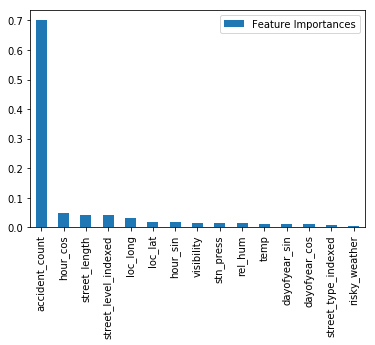

In [36]:
from random_forest import features_col
import pandas as pd
fi = pd.DataFrame(model
                  .stages[1]
                  .featureImportances
                  .toArray())
fi.index = features_col
fi.columns = ['Feature Importances']
fi = fi.sort_values(by=['Feature Importances'], ascending=False)
fi.plot.bar()

In [37]:
from random_forest import compute_precision_recall_graph
precision_recall = compute_precision_recall_graph(predictions, 20)

In [38]:
# from random_forest import compute_precision_recall
# compute_precision_recall(predictions, 0.83)

In [39]:
# precision_recall.to_csv('data/precision_recall_brf_cheat.csv')

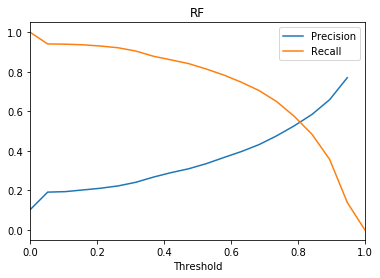

In [40]:
precision_recall.plot(x='Threshold', title='RF')

In [41]:
# precision_recall.plot(x='Recall', y='Precision', ylim=(0,1))

In [42]:
precision_recall

,Threshold,Precision,Recall
0,0.000000,0.102028,1.000000
1,0.052632,0.191169,0.940735
2,0.105263,0.193687,0.939591
3,0.157895,0.202194,0.936459
4,0.210526,0.210803,0.930194
5,0.263158,0.222716,0.921394
6,0.315789,0.240942,0.904887
7,0.368421,0.267165,0.878536
8,0.421053,0.289782,0.860140
9,0.473684,0.309341,0.841247


In [43]:
precision_recall.to_csv('results/rf_pr_tab.csv')